In [2]:
import matplotlib.pyplot as plt
from PIL import Image
from active_learning import ActiveLearning, PetDataset
import os 
from sklearn.model_selection import train_test_split
import random
import glob
from torch import nn
from torchvision.models import resnet34, ResNet34_Weights, resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

In [3]:
data_path = "./data/oxford-iiit-pet/images/"

In [4]:


all_images = glob.glob("data/oxford-iiit-pet/images/*.jpg")
all_images.sort()  # Ensure reproducibility

# Split into train (70%) and temp (30%)
train_imgs, temp_imgs = train_test_split(all_images, test_size=0.3, random_state=42)

# Split temp into val and test (15% each)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

Train: 5173, Val: 1108, Test: 1109


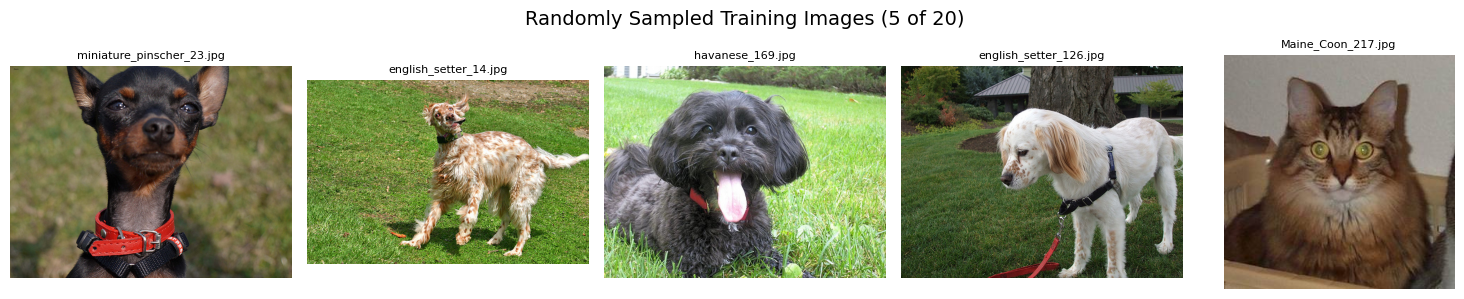

In [4]:
sampled_imgs = random.sample(train_imgs, 20)

# Display 5 of them
def show_images(image_paths, title="Sampled Images", n=5):
    plt.figure(figsize=(15, 3))
    for i, img_path in enumerate(image_paths[:n]):
        img = Image.open(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(img_path), fontsize=8)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

show_images(sampled_imgs, "Randomly Sampled Training Images (5 of 20)")

In [7]:
def evaluate_model(model, dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            out = model(x)
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += len(y)
    return correct / total

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_set = PetDataset(test_imgs, transform=transform)

In [8]:
baseline = resnet18(weights=ResNet18_Weights.DEFAULT)
baseline.fc = nn.Linear(baseline.fc.in_features, 2)
baseline.eval()
print("Baseline Accuracy (no fine-tuning):", evaluate_model(baseline, test_set))

Baseline Accuracy (no fine-tuning): 0.5572587917042381


Querying samples for least confidence...
Querying samples for maximum entropy...
Querying samples for K-Means...
Querying samples for hybrid DBAL...


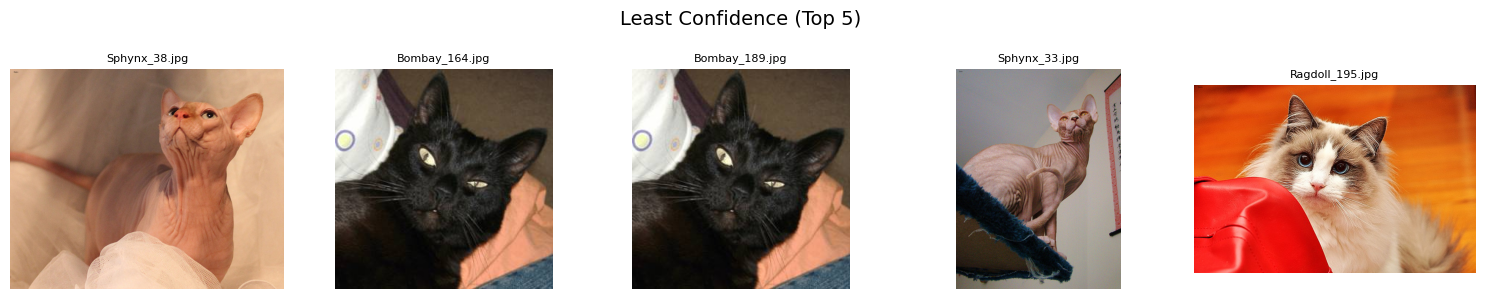

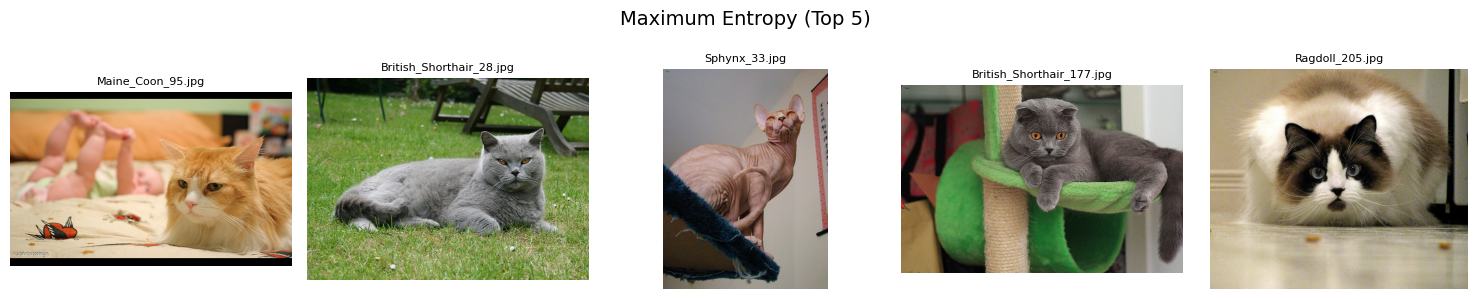

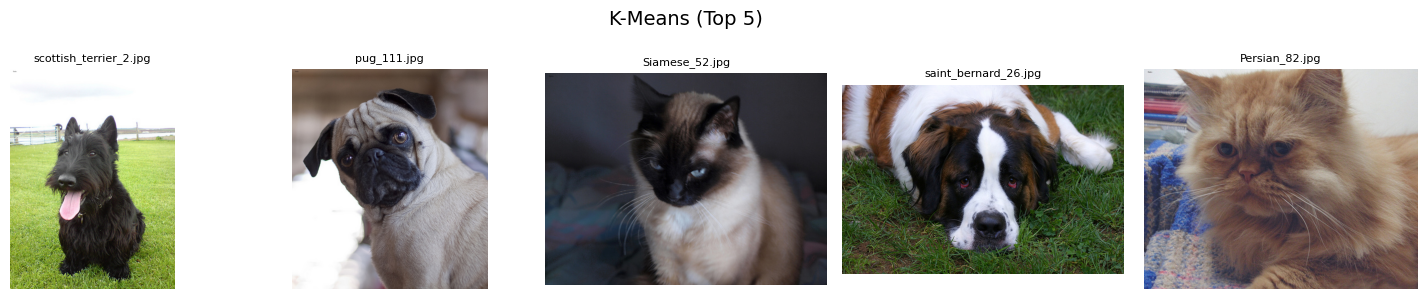

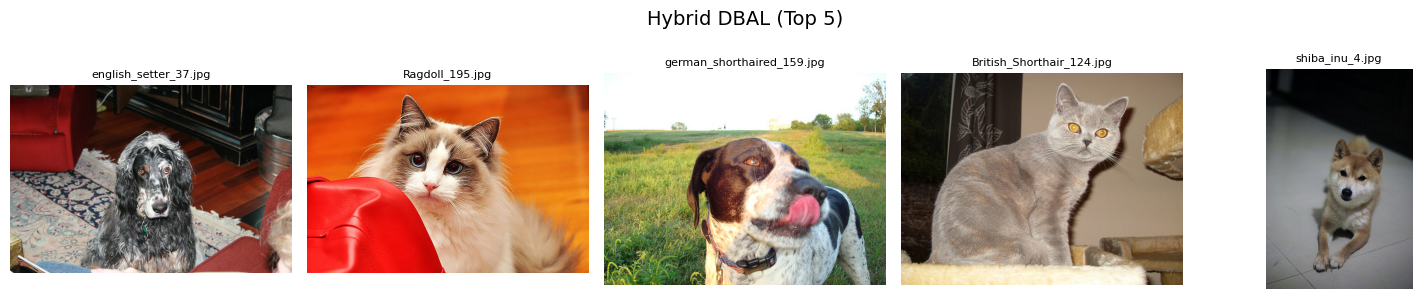

In [10]:
al = ActiveLearning(k=20, beta=10)
al.set_training_pool(train_imgs)


print("Querying samples for least confidence...")
selected_lc = al.query_least_confidence(data_path)
print("Querying samples for maximum entropy...")    
selected_entropy = al.query_max_entropy(data_path)
print("Querying samples for K-Means...")
selected_kmeans = al.query_kmeans(data_path)
print("Querying samples for hybrid DBAL...")
selected_hybrid = al.query_hybrid()

# Show the top 5 selected samples per strategy
show_images(selected_lc, "Least Confidence (Top 5)")
show_images(selected_entropy, "Maximum Entropy (Top 5)")
show_images(selected_kmeans, "K-Means (Top 5)")
show_images(selected_hybrid[:5], "Hybrid DBAL (Top 5)")

In [22]:
from active_learning import cat_breeds_lower, dog_breeds_lower
class LabeledFromPathDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("RGB")
        class_name = "_".join(os.path.basename(path).split("_")[:-1]).lower()
        if class_name in cat_breeds_lower:
            label = 0
        elif class_name in dog_breeds_lower:
            label = 1
        else:
            raise ValueError(f"Unknown class: {path}")
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.image_paths)

# Create dataloader
hybrid_dataset = LabeledFromPathDataset(selected_hybrid, transform=transform)
hybrid_loader = DataLoader(hybrid_dataset, batch_size=8, shuffle=True)

# === STEP 3: Fine-tune ResNet34 on the 20 selected samples ===
model = resnet34(weights=ResNet34_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

model.train()
for epoch in range(5):
    for x, y in hybrid_loader:
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

# === STEP 4: Evaluate on the test set ===
test_dataset = PetDataset(test_imgs, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        out = model(x)
        pred = out.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += len(y)

acc = correct / total
print(f"Accuracy after fine-tuning on 20 hybrid-selected images: {acc:.4f}")

Accuracy after fine-tuning on 20 hybrid-selected images: 0.6763


In [23]:
# === STEP A: Dataset & loader for 20 randomly selected images ===
random_dataset = LabeledFromPathDataset(sampled_imgs, transform=transform)
random_loader = DataLoader(random_dataset, batch_size=8, shuffle=True)

# === STEP B: Initialize new ResNet model ===
model_random = resnet34(weights=ResNet34_Weights.DEFAULT)
model_random.fc = nn.Linear(model_random.fc.in_features, 2)
optimizer = torch.optim.Adam(model_random.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# === STEP C: Fine-tune model on random 20 samples ===
model_random.train()
for epoch in range(5):
    for x, y in random_loader:
        optimizer.zero_grad()
        output = model_random(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

# === STEP D: Evaluate model fine-tuned on random samples ===
model_random.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        out = model_random(x)
        pred = out.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += len(y)

random_acc = correct / total
print(f"Accuracy after fine-tuning on 20 random samples: {random_acc:.4f}")

Accuracy after fine-tuning on 20 random samples: 0.6564


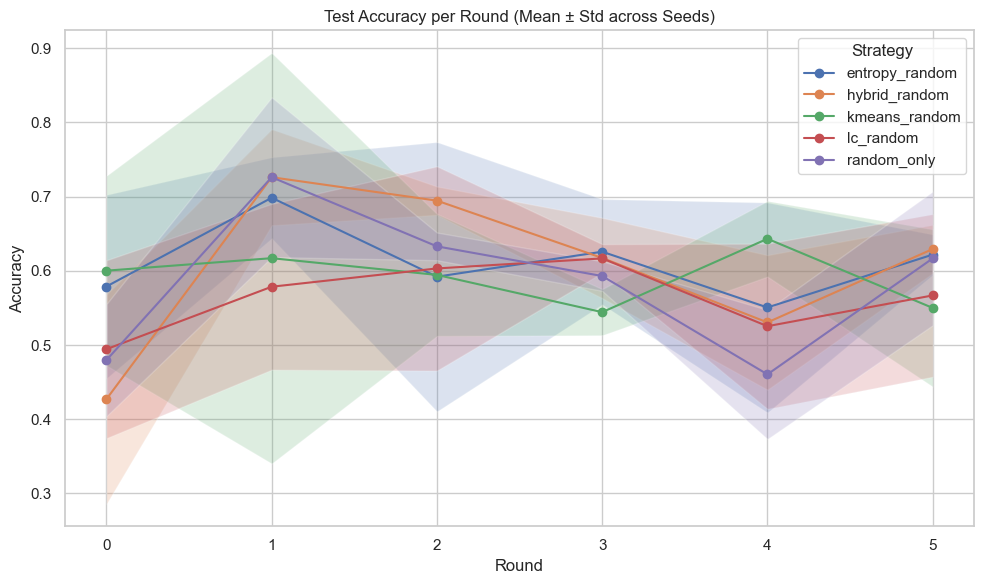

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df = pd.read_csv("active_learning_eval.csv")

# Aggregate mean and std accuracy per round & strategy
agg = df.groupby(["round", "strategy"]).agg(
    accuracy_mean=("accuracy", "mean"),
    accuracy_std=("accuracy", "std")
).reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
for strategy in agg["strategy"].unique():
    subset = agg[agg["strategy"] == strategy]
    rounds = subset["round"].to_numpy(dtype=int)
    means = subset["accuracy_mean"].to_numpy(dtype=float)
    stds = subset["accuracy_std"].to_numpy(dtype=float)

    plt.plot(rounds, means, marker="o", label=strategy)
    plt.fill_between(rounds, means - stds, means + stds, alpha=0.2)

plt.title("Test Accuracy per Round (Mean ± Std across Seeds)")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend(title="Strategy")
plt.tight_layout()
plt.show()

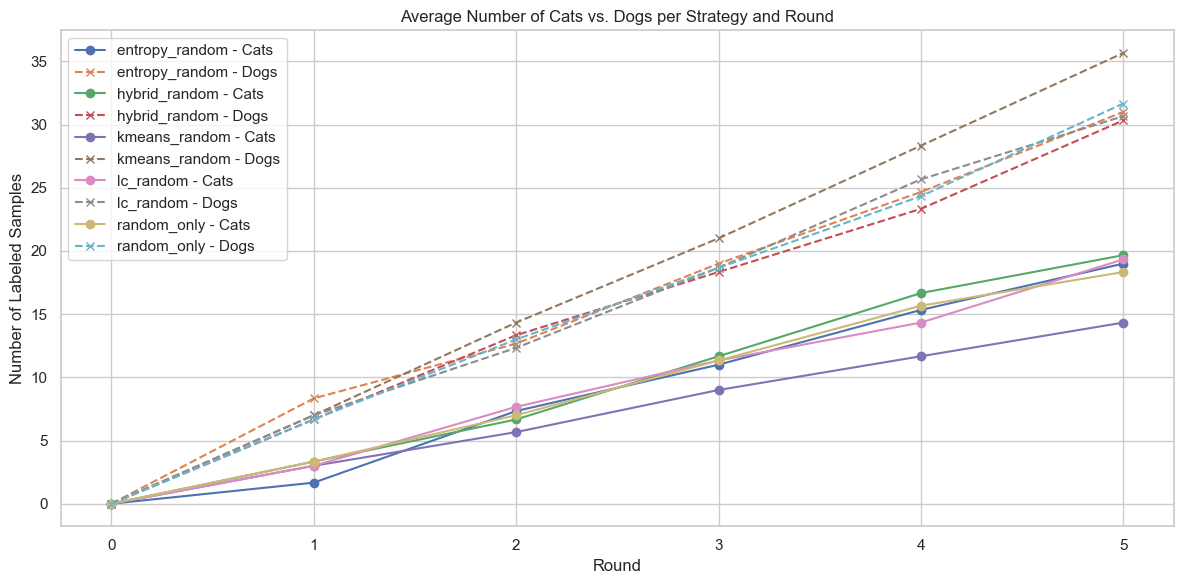

In [2]:
# Aggregate average class counts per round & strategy
balance_df = df.groupby(["round", "strategy"]).agg(
    cats_mean=("num_cats", "mean"),
    dogs_mean=("num_dogs", "mean")
).reset_index()

# Plot
plt.figure(figsize=(12, 6))
for strategy in balance_df["strategy"].unique():
    subset = balance_df[balance_df["strategy"] == strategy]
    rounds = subset["round"].to_numpy(dtype=int)
    cats = subset["cats_mean"].to_numpy(dtype=float)
    dogs = subset["dogs_mean"].to_numpy(dtype=float)

    plt.plot(rounds, cats, label=f"{strategy} - Cats", marker="o", linestyle="-")
    plt.plot(rounds, dogs, label=f"{strategy} - Dogs", marker="x", linestyle="--")

plt.title("Average Number of Cats vs. Dogs per Strategy and Round")
plt.xlabel("Round")
plt.ylabel("Number of Labeled Samples")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

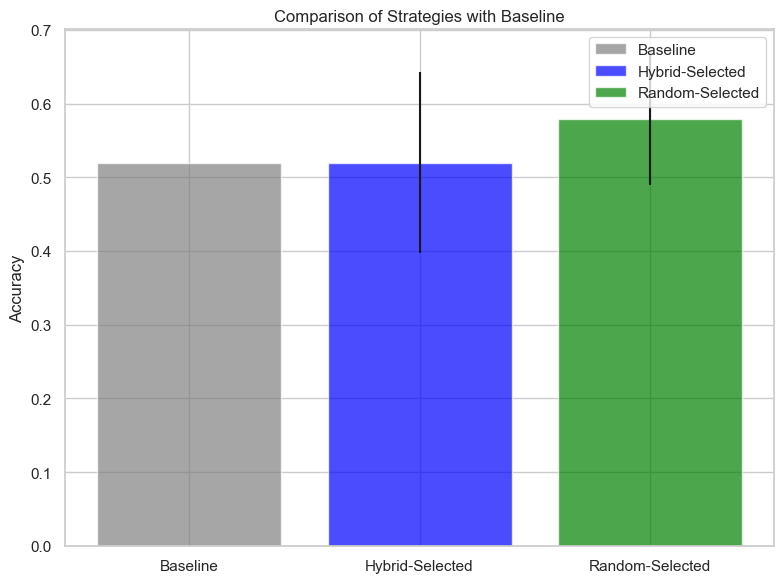

In [3]:
import numpy as np

import matplotlib.pyplot as plt

# Extract data for the two strategies and baseline
strategies = ["hybrid-selected", "random-selected"]
hybrid_accuracies = [0.6411, 0.4860, 0.4500, 0.3463, 0.6763]
random_accuracies = [0.6934, 0.4812, 0.4761, 0.5861, 0.6564]
baseline_accuracy = 0.5193868349864743

# Calculate mean and std for each strategy
hybrid_mean = np.mean(hybrid_accuracies)
hybrid_std = np.std(hybrid_accuracies)
random_mean = np.mean(random_accuracies)
random_std = np.std(random_accuracies)

# Plot
plt.figure(figsize=(8, 6))
x = np.arange(len(strategies) + 1)  # Positions for bars

# Plot bars with error bars
plt.bar(x[0], baseline_accuracy, yerr=0, label="Baseline", color="gray", alpha=0.7)
plt.bar(x[1], hybrid_mean, yerr=hybrid_std, label="Hybrid-Selected", color="blue", alpha=0.7)
plt.bar(x[2], random_mean, yerr=random_std, label="Random-Selected", color="green", alpha=0.7)

# Add labels and legend
plt.xticks(x, ["Baseline", "Hybrid-Selected", "Random-Selected"])
plt.ylabel("Accuracy")
plt.title("Comparison of Strategies with Baseline")
plt.legend()
plt.tight_layout()
plt.show()

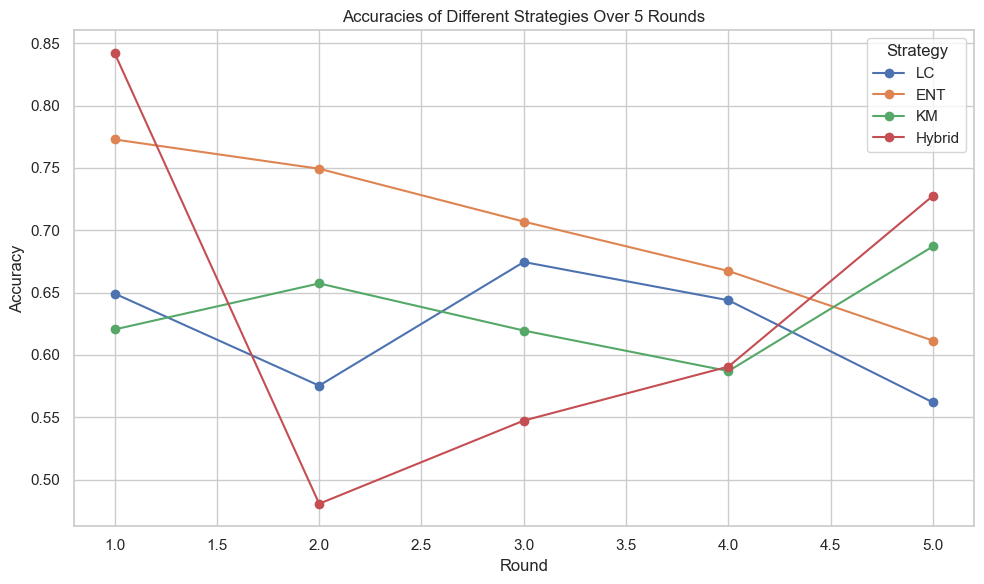

In [5]:
# Define the accuracies for each strategy over the 5 rounds
rounds = [1, 2, 3, 4, 5]
lc_accuracies = [0.6492, 0.5753, 0.6745, 0.6438, 0.5618]
ent_accuracies = [0.7728, 0.7493, 0.7069, 0.6673, 0.6114]
km_accuracies = [0.6204, 0.6573, 0.6195, 0.5870, 0.6871]
hybrid_accuracies = [0.8422, 0.4806, 0.5473, 0.5906, 0.7277]

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(rounds, lc_accuracies, marker='o', label='LC')
plt.plot(rounds, ent_accuracies, marker='o', label='ENT')
plt.plot(rounds, km_accuracies, marker='o', label='KM')
plt.plot(rounds, hybrid_accuracies, marker='o', label='Hybrid')

# Add labels, title, and legend
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracies of Different Strategies Over 5 Rounds')
plt.legend(title='Strategy')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Define the accuracies for each strategy over the 5 rounds
use the accuracies provided in the text to first average per strategy for each round (using the three accuracies from the 3 different seeds) and then plot for each strategy (5 in total) the accuracies over the 5 rounds

seed,round,strategy,accuracy,num_cats,num_dogs
42,0,lc_random,0.4382326420198377,0,0
42,0,entropy_random,0.4418394950405771,0,0
42,0,kmeans_random,0.4526600541027953,0,0
42,0,hybrid_random,0.5897204688908927,0,0
42,0,random_only,0.4147880973850316,0,0
42,1,lc_random,0.6041478809738503,4,6
42,1,entropy_random,0.6825969341749324,2,8
42,1,kmeans_random,0.6393146979260595,1,9
42,1,hybrid_random,0.6853020739404869,6,4
42,1,random_only,0.7971145175834085,4,6
42,2,lc_random,0.6753832281334535,10,10
42,2,entropy_random,0.7231740306582507,9,11
42,2,kmeans_random,0.5157799819657349,4,16
42,2,hybrid_random,0.7123534715960325,8,12
42,2,random_only,0.6131650135256989,10,10
42,3,lc_random,0.5951307484220018,14,16
42,3,entropy_random,0.6564472497745717,13,17
42,3,kmeans_random,0.5311091073038774,8,22
42,3,hybrid_random,0.6411181244364292,12,18
42,3,random_only,0.6149684400360685,12,18
42,4,lc_random,0.6438232642019838,18,22
42,4,entropy_random,0.5680793507664562,17,23
42,4,kmeans_random,0.5852119026149685,13,27
42,4,hybrid_random,0.6348061316501352,15,25
42,4,random_only,0.4905320108205591,16,24
42,5,lc_random,0.5689810640216412,22,28
42,5,entropy_random,0.6275924256086565,23,27
42,5,kmeans_random,0.478809738503156,17,33
42,5,hybrid_random,0.6275924256086565,16,34
42,5,random_only,0.6618575293056808,19,31
43,0,lc_random,0.6321009918845807,0,0
43,0,entropy_random,0.6816952209197475,0,0
43,0,kmeans_random,0.6753832281334535,0,0
43,0,hybrid_random,0.35166816952209196,0,0
43,0,random_only,0.4616771866546438,0,0
43,1,lc_random,0.6753832281334535,1,9
43,1,entropy_random,0.6537421100090172,1,9
43,1,kmeans_random,0.8818755635707844,4,6
43,1,hybrid_random,0.8007213706041478,3,7
43,1,random_only,0.7790802524797115,2,8
43,2,lc_random,0.44454463480613166,4,16
43,2,entropy_random,0.38503155996393146,4,16
43,2,kmeans_random,0.587917042380523,6,14
43,2,hybrid_random,0.69702434625789,9,11
43,2,random_only,0.6357078449053201,6,14
43,3,lc_random,0.6230838593327321,6,24
43,3,entropy_random,0.6762849413886384,8,22
43,3,kmeans_random,0.5798016230838593,9,21
43,3,hybrid_random,0.5554553651938684,14,16
43,3,random_only,0.587917042380523,10,20
43,4,lc_random,0.42290351668169524,9,31
43,4,entropy_random,0.4012623985572588,14,26
43,4,kmeans_random,0.6807935076645627,10,30
43,4,hybrid_random,0.4860234445446348,19,21
43,4,random_only,0.5284039675383229,14,26
43,5,lc_random,0.6753832281334535,15,35
43,5,entropy_random,0.5924256086564472,15,35
43,5,kmeans_random,0.4995491433724076,12,38
43,5,hybrid_random,0.5978358881875564,23,27
43,5,random_only,0.6753832281334535,16,34
44,0,lc_random,0.41298467087466184,0,0
44,0,entropy_random,0.6131650135256989,0,0
44,0,kmeans_random,0.672678088367899,0,0
44,0,hybrid_random,0.33994589720468893,0,0
44,0,random_only,0.5626690712353472,0,0
44,1,lc_random,0.45626690712353474,4,6
44,1,entropy_random,0.7592425608656447,2,8
44,1,kmeans_random,0.33002705139765554,4,6
44,1,hybrid_random,0.6925157799819658,1,9
44,1,random_only,0.6023444544634806,4,6
44,2,lc_random,0.6898106402164111,9,11
44,2,entropy_random,0.6681695220919748,9,11
44,2,kmeans_random,0.6798917944093779,7,13
44,2,hybrid_random,0.6744815148782687,3,17
44,2,random_only,0.6501352569882777,5,15
44,3,lc_random,0.6321009918845807,14,16
44,3,entropy_random,0.5446348061316502,12,18
44,3,kmeans_random,0.5220919747520288,10,20
44,3,hybrid_random,0.6555455365193869,9,21
44,3,random_only,0.5761947700631199,12,18
44,4,lc_random,0.5094679891794409,16,24
44,4,entropy_random,0.6825969341749324,15,25
44,4,kmeans_random,0.6636609558160504,12,28
44,4,hybrid_random,0.47069431920649235,16,24
44,4,random_only,0.3624887285843102,17,23
44,5,lc_random,0.45626690712353474,21,29
44,5,entropy_random,0.6456266907123535,19,31
44,5,kmeans_random,0.6717763751127142,14,36
44,5,hybrid_random,0.6627592425608656,20,30
44,5,random_only,0.5130748422001803,20,30
# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(rounds, lc_accuracies, marker='o', label='LC')
plt.plot(rounds, ent_accuracies, marker='o', label='ENT')
plt.plot(rounds, km_accuracies, marker='o', label='KM')
plt.plot(rounds, hybrid_accuracies, marker='o', label='Hybrid')

# Add labels, title, and legend
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracies of Different Strategies Over 5 Rounds')
plt.legend(title='Strategy')
plt.grid(True)
plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (981580064.py, line 2)

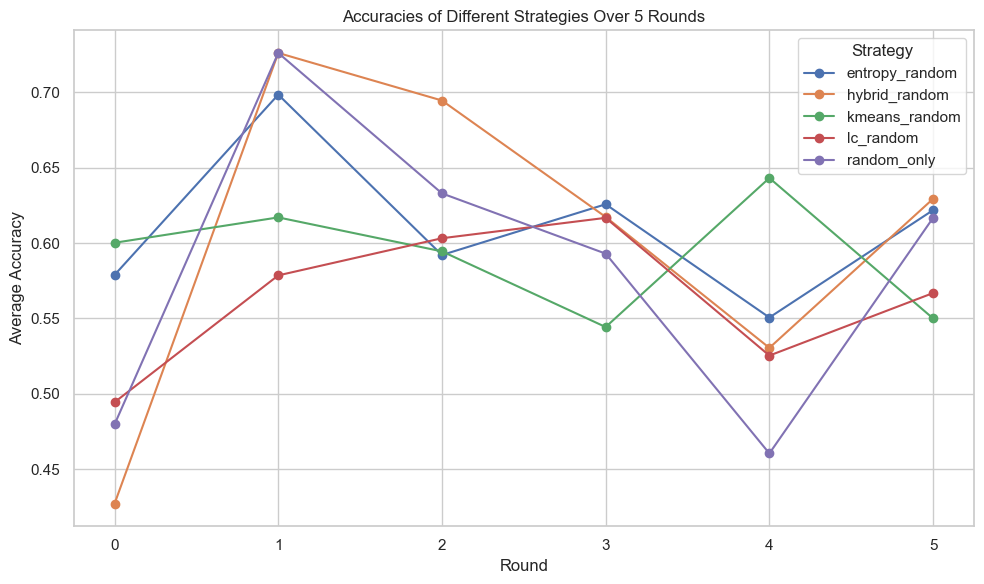

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV data into a DataFrame
df = pd.read_csv("active_learning_eval_resnet34.csv")  # Replace with actual path if loading from file

# Filter only the first 5 rounds (rounds 0 to 5)
df_filtered = df[df["round"] < 6]

# Average accuracy per strategy and round
avg_accuracies = df_filtered.groupby(["round", "strategy"])["accuracy"].mean().unstack()

# Plotting
plt.figure(figsize=(10, 6))
for strategy in avg_accuracies.columns:
    plt.plot(avg_accuracies.index, avg_accuracies[strategy], marker='o', label=strategy)

plt.xlabel('Round')
plt.ylabel('Average Accuracy')
plt.title('Accuracies of Different Strategies Over 5 Rounds')
plt.legend(title='Strategy')
plt.grid(True)
plt.tight_layout()
plt.show()
